In [49]:
import sys
sys.path.append('..\\helpers')

import cv2
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
import pandas as pd
import seaborn as sns
from PIL import Image, ImageDraw
from functools import reduce

from pywt import dwt2
import math
from scipy import ndimage


# From helpers directory
from preprocessing import Preprocessor
from morphological_sifter import MorphologicalSifter

import display


preprocessor = Preprocessor()
mms = MorphologicalSifter()

plt.rcParams['figure.figsize'] = (20, 18)
plt.style.use('classic')
plt.subplots_adjust(wspace=0, hspace=0)
sns.set()

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 640x480 with 0 Axes>

## Exploratory Data Analysis

Understanding data structure and setting global variables

In [50]:
dataset_folder_paths = [(x[0].split("\\")[-1], x[0]) for x in os.walk("..\\dataset")][1:]
dataset_folder_paths

[('groundtruth', '..\\dataset\\groundtruth'),
 ('images', '..\\dataset\\images'),
 ('masks', '..\\dataset\\masks'),
 ('overlay', '..\\dataset\\overlay'),
 ('processed', '..\\dataset\\processed'),
 ('images', '..\\dataset\\processed\\images'),
 ('overlay', '..\\dataset\\processed\\overlay')]

Preparing a dataframe to summarize the dataset

In [51]:
positive_labelled_images = []
negative_labelled_images = []

dataset = []

labels = ["positives", "negatives"]

for idx, object in enumerate(labels):
        with open(f'..\\dataset\\{str(object)}.txt') as f:
            lines = f.read().splitlines()
            
            for line in lines:
                if line != "":
                    new_path = os.path.join(dataset_folder_paths[1][1], line)
                    
                    dataset.append((str(object), line))
                    positive_labelled_images.append(new_path) if str(object) == 'positives' else negative_labelled_images.append(new_path)

dataset_df = pd.DataFrame(dataset, columns=['class', 'filename'])
dataset_df.sample(10)

,class,filename
279,negatives,50996137_71c1a60d57c5322f_MG_R_CC_ANON.tif
192,negatives,24055203_606e9b184978a350_MG_L_CC_ANON.tif
373,negatives,53581887_21e6cc12630e5e9f_MG_R_ML_ANON.tif
17,positives,20588562_bf1a6aaadb05e3df_MG_L_CC_ANON.tif
55,positives,22670809_0b7396cdccacca82_MG_R_CC_ANON.tif
366,negatives,53581237_80123a24997098dc_MG_R_ML_ANON.tif
241,negatives,50993616_b03f1dd34eb3c55f_MG_L_ML_ANON.tif
193,negatives,24055328_1e10aef17c9fe149_MG_R_ML_ANON.tif
319,negatives,50998258_f34ee0ab6591b792_MG_R_CC_ANON.tif
185,negatives,22679036_b9a4da5f2dae63a9_MG_L_ML_ANON.tif


Dataset Summary

In [52]:
dataset_df.describe()

,class,filename
count,410,410
unique,2,410
top,negatives,20586908_6c613a14b80a8591_MG_R_CC_ANON.tif
freq,303,1


In [53]:
# Checking if we have duplicate files, all good!
len(dataset_df["filename"].unique())

410

<Axes: >

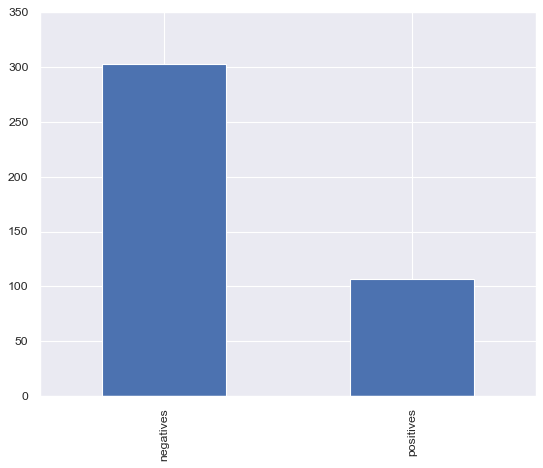

In [54]:
# balanced classes
dataset_df['class'].value_counts().plot(kind='bar')

Visualizing the dataset

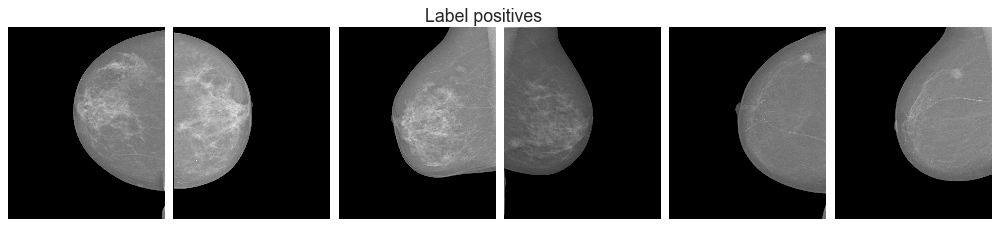

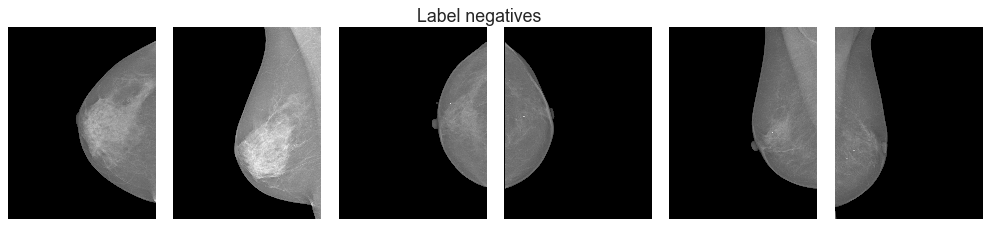

In [55]:
for idx, lbl in enumerate(labels):
    nrows, ncols = 1, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 3))
    plt.subplots_adjust(wspace=0, hspace=1)

    for idx, fname in enumerate(dataset_df.loc[dataset_df['class'] == lbl]['filename'][:ncols]):
        img = Image.open(os.path.join(dataset_folder_paths[1][1],fname))
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(np.array(img), cmap='gray')
        fig.suptitle(f'Label {lbl}', fontsize=16)
        plt.axis('off')


## Pre-processing

Pre-processing steps:
1. Image rescaling by a factor of 4
2. The breast profile is pre-segmented using a simple threshold and then the redundant background is cropped away in the dataset.
3. The pixel values in the image are linearly rescaled to 16-bit
4. Contrast limited adaptive histogram equalization (CLAHE) is then applied. The number of tiles in CLAHE is set as {4, 4}, which is arbitrarily chosen, and the contrast enhancement limit is set as 0.01 (default).

Those processes are done firstly on a single image for testing purpsose before modifying the original dataset.

Resized Image Shape: (1634, 1331, 3)
Gray Image Shape: (1634, 1331)
Thresholded Mask Shape: (1634, 1331)


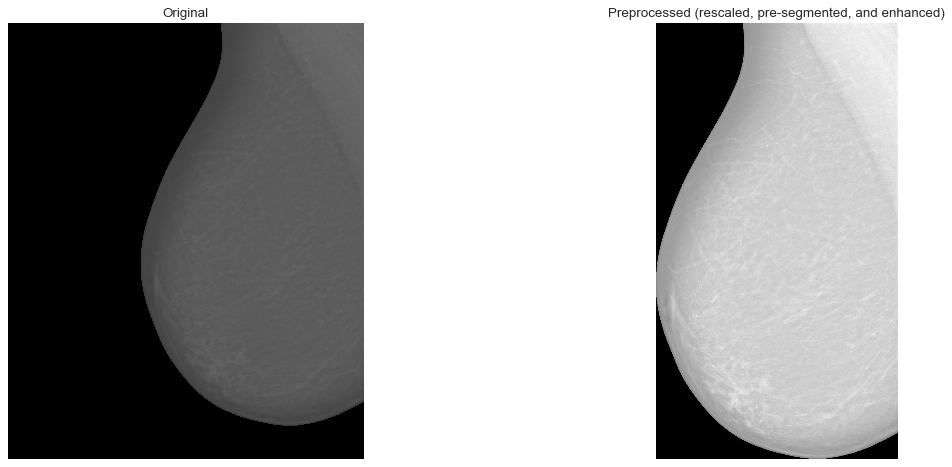

In [56]:
# Reading a single image
random_idx = random.randint(0,70)

img_name = os.listdir(os.path.join(dataset_folder_paths[0][1]))[random_idx]
img_path = os.path.join(dataset_folder_paths[1][1], img_name)

# original image
img = cv2.imread(
    img_path)

# 1. resizing image with a factor of 4 using INTER_CUBIC (bi-cubic) interpolation
scale_factor = 0.4
img_resized = cv2.resize(img.copy(), None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
print(f"Resized Image Shape: {img_resized.shape}")

img_gray = cv2.cvtColor(img_resized.copy(), cv2.COLOR_BGR2GRAY)
print(f"Gray Image Shape: {img_gray.shape}")


# 2. Pre-segmenting using thresholding technique and cropping redundant background
# https://stackoverflow.com/questions/63575738/remove-letter-artifacts-from-mammography-image
# The first argument is the source image, which should be a grayscale image. The second argument is 
# the threshold value which is used to classify the pixel values. The third argument is the maximum value
# which is assigned to pixel values exceeding the threshold. 
thresholding_mask = cv2.threshold(img_gray.copy(), 30, 255, cv2.THRESH_BINARY)[1]
print(f"Thresholded Mask Shape: {thresholding_mask.shape}")

# To remove redundant image, lets find the contours from the mask we generated
contours, _ = cv2.findContours(thresholding_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)
contour_image = cv2.drawContours(img_gray.copy(), [largest_contour], -1, (255, 255, 255), 3)
cropped_image = img_gray.copy()[y:y+h, x:x+w]


# 3. Rescale (Normalize) the image to 16-bit unsigned integer (0-65535)
# Note, clahe expects 8-bit (0-255) not 16 ..
rescaled_img = cv2.normalize(cropped_image.copy(), None, 0, 255, cv2.NORM_MINMAX)


# 4. Applying CLAHE
clahe = cv2.createCLAHE(clipLimit=0.01, tileGridSize=(4,4))
clahe_img = clahe.apply(rescaled_img.copy())

imgs = {
    "Original": img, 
#     "Threshold Mask": thresholding_mask, 
#     "Contour on Gray Image": contour_image, 
#     "Cropped Image (Grayscale Version)": cropped_image, 
#     "Rescaled 16-bit":rescaled_img,
    "Preprocessed (rescaled, pre-segmented, and enhanced)": clahe_img
}

display.plot_figures(imgs, 1,2) 


2023-04-24 17:25:22.880 | INFO     | preprocessing:fit:70 - Started processing pipeline.
100%|███| 1/1 [00:00<00:00,  4.06it/s]
2023-04-24 17:25:23.132 | INFO     | preprocessing:fit:115 - Finished processing 107 files in approximately 0.252 seconds.


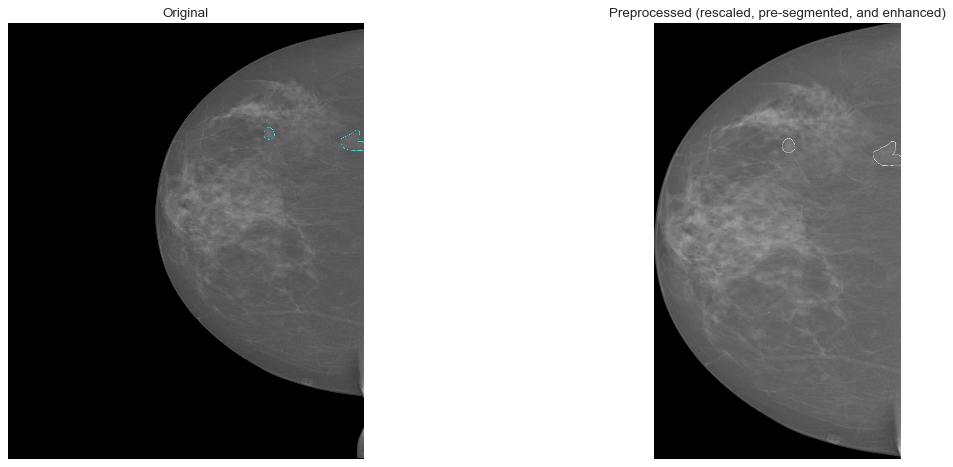

In [57]:
# All of the above is now implemented in a separate class and can be applied using the following line of code
preprocessor.fit(dataset_path=dataset_folder_paths[3][1], 
                 process_n=1, 
                 plot=True, 
                 export_processed=False)

## Region Candidate Generation

Two stages were proposed:
1. Multi-scale morphological shifters
2. Multi-level Otsu thresholding

1. Multi-scale Morphological Sifters

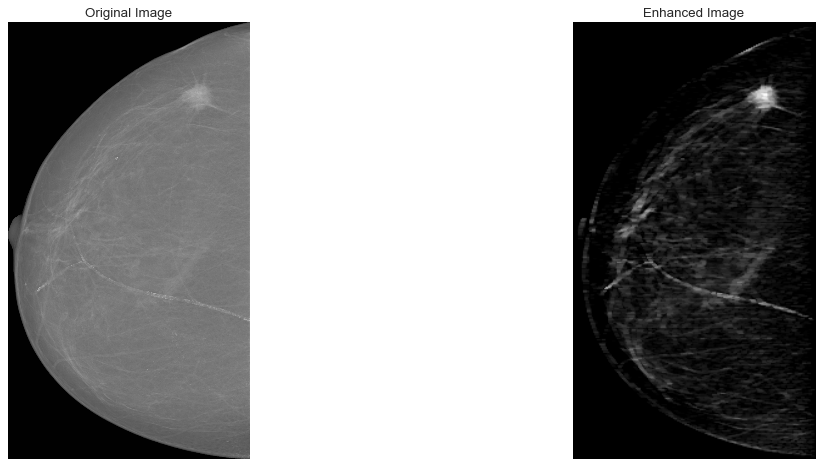

In [89]:
image_input_name = '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.tif'

enhanced_image = mms.fit(image_input_name, plot=True)

383